### Цель работы:

изучение алгоритмов и методов кластеризации на практике.
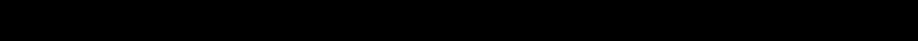
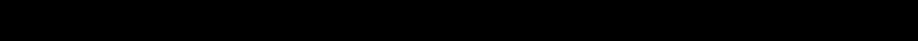

### Порядок выполнения работы:

1. Использовать функцию для создания набора данных
2. Получить с помощью функции набор данных
3. Провести стандартизацию данных
4. С помощью метода .fit_predict обучить модель для кластеризации методом Kmeans для трёх кластеров. Выполнить предсказание. Получить метки кластеров.
5. Провести визуализацию кластеров с помощью scatter. Построить графики. Пометить
на графике центры кластеров. Покрасить объекты из разных кластеров разными
цветами.
6. Посчитать коэффициент силуэта.
7. Повторить пункты 4-6 для n_clusters = 2 и n_clusters = 4. Сравнить результаты и сделать
выводы.
8. Построить график по “методу локтя” и сделать выводы
9. Выполнить кластеризацию по вариантам

### Вариант задания - 3


Набор данных

_telecom_churn.csv_

Информация о клиентах:
* age — возраст клиента (лет), числовой.
* gender — пол клиента: M (мужчина), F (женщина), категориальный.
* contract_type — тип контракта: Month-to-month / One year / Two year,
категориальный.
* payment_method — способ оплаты: Electronic check / Credit card / Bank transfer /
Mailed check, категориальный.
* tenure_months — стаж обслуживания в компании (месяцы), числовой.
* monthly_charges — ежемесячные платежи, USD/мес, числовой.
* total_charges — накопленные платежи за весь период, USD, числовой.
* avg_call_minutes — среднее количество минут звонков в месяц, числовой.
* num_support_tickets — число обращений в поддержку за последние месяцы,
целочисленный счётчик.
* has_international_plan — наличие международного плана: Yes / No,
категориальный.
* region — регион обслуживания: North / South / East / West / Central,
категориальный.
* Churn — целевой класс: 1  ушёл (расторг контракт), 0  остался.

---

### Загрузка данных

Был произведён импорт ключевых библиотек Python, которые будут использоваться на протяжении всей лабораторной работы. pandas и numpy необходимы для операций с данными, matplotlib и seaborn — для визуализации, а модули sklearn и scipy предоставляют инструменты для предобработки данных, кластеризации и вычисления метрик качества.

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score

from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

Для анализа был загружен датасет telecom_churn.csv, содержащий 3016 записей о клиентах телеком-компании. Структура данных соответствует описанию: присутствуют числовые признаки (возраст, стаж, платежи) и категориальные (тип контракта, способ оплаты, регион). Пропущенных значений и дубликатов в данных не обнаружено, что упрощает дальнейшую предобработку.

In [181]:
df = pd.read_csv('telecom_churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3016 entries, 0 to 3015
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     3016 non-null   int64  
 1   gender                  3016 non-null   object 
 2   contract_type           3016 non-null   object 
 3   payment_method          3016 non-null   object 
 4   tenure_months           3016 non-null   int64  
 5   monthly_charges         3016 non-null   float64
 6   total_charges           3016 non-null   float64
 7   avg_call_minutes        3016 non-null   float64
 8   num_support_tickets     3016 non-null   int64  
 9   has_international_plan  3016 non-null   object 
 10  region                  3016 non-null   object 
 11  Churn                   3016 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 282.9+ KB


---

### 1. Предобработка данных

В датасете нет пропущенных значений.

In [182]:
df.isnull().sum()

age                       0
gender                    0
contract_type             0
payment_method            0
tenure_months             0
monthly_charges           0
total_charges             0
avg_call_minutes          0
num_support_tickets       0
has_international_plan    0
region                    0
Churn                     0
dtype: int64

В датасете нет дубликатов.

In [183]:
df.duplicated().sum()

np.int64(0)

Все данные имеют правильный тип данных согласно описанию.

In [184]:
df.dtypes

age                         int64
gender                     object
contract_type              object
payment_method             object
tenure_months               int64
monthly_charges           float64
total_charges             float64
avg_call_minutes          float64
num_support_tickets         int64
has_international_plan     object
region                     object
Churn                       int64
dtype: object

---

Была создана синтетическая выборка для изучения алгоритмов кластеризации. Данные состоят из 150 точек, разделённых на три чётко различимых группы. Каждый кластер сгенерирован вокруг своего центра путём добавления случайного шума к базовым координатам. После создания данные были перемешаны, чтобы исключить возможную последовательность, связанную с порядком генерации. Такой набор данных позволяет наглядно проверить способность алгоритмов находить заранее известную групповую структуру.

In [185]:
n = 50  # количество точек в каждом кластере
seed = 0  # для воспроизводимости

np.random.seed(seed)

shift_matrix = np.array([[3, 3],
                         [6, 9],
                         [9, 3]])

data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))

data = np.swapaxes(data, 1, 2)
data = data.reshape((-1, 2))

data *= np.array([[20, 0.5]])

df_synth = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]})
df_synth = df_synth.sample(frac=1.0, random_state=seed)

График наглядно демонстрирует структуру сгенерированного набора данных. Можно наблюдать три компактных и хорошо отделённых друг от друга группы точек. Красными звёздами отмечены исходные центры, вокруг которых эти кластеры были сформированы. Данные обладают явной группировкой, что делает их удобными для тестирования алгоритмов кластеризации. Размерность датасета составляет 150 строк и 2 признака, причём признаки имеют разный масштаб: значения X лежат в диапазоне от 8.9 до 225.2, а значения Y — от 0.1 до 5.6, что подтверждает необходимость предварительной стандартизации перед анализом.

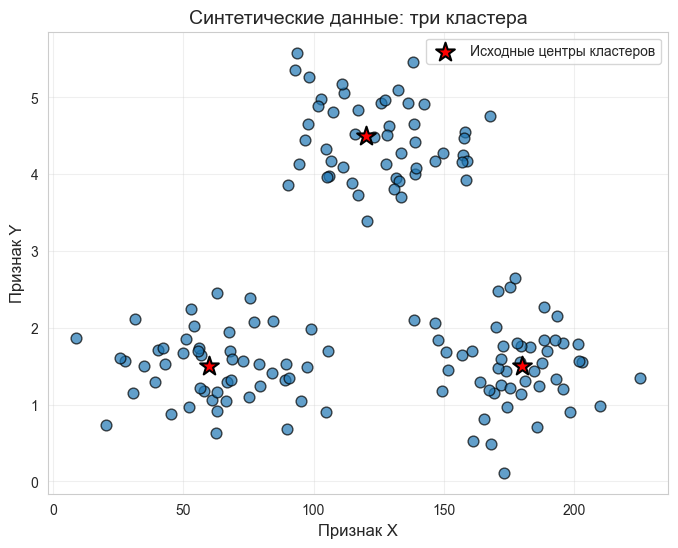

Общее количество точек: 150
Размерность данных: (150, 2)
Диапазон значений X: [8.9, 225.2]
Диапазон значений Y: [0.1, 5.6]


In [186]:
# Визуализация полученного набора данных
plt.figure(figsize=(8, 6))
plt.scatter(df_synth['x'], df_synth['y'], alpha=0.7, edgecolors='k', s=60)
plt.title('Синтетические данные: три кластера', fontsize=14)
plt.xlabel('Признак X', fontsize=12)
plt.ylabel('Признак Y', fontsize=12)
plt.grid(True, alpha=0.3)

# Показываем центры исходных кластеров
centers = shift_matrix * np.array([[20, 0.5]])
plt.scatter(centers[:, 0], centers[:, 1], s=200, marker='*', color='red',
            label='Исходные центры кластеров', edgecolors='black', linewidth=1.5)
plt.legend()
plt.show()

# Основная информация о наборе данных
print(f"Общее количество точек: {len(df_synth)}")
print(f"Размерность данных: {df_synth.shape}")
print(f"Диапазон значений X: [{df_synth['x'].min():.1f}, {df_synth['x'].max():.1f}]")
print(f"Диапазон значений Y: [{df_synth['y'].min():.1f}, {df_synth['y'].max():.1f}]")

Сравнительная визуализация подтверждает успешное выполнение стандартизации. На левом графике данные представлены в исходном масштабе, где различие в дисперсии признаков X и Y очевидно. После применения StandardScaler (правый график) оба признака приводятся к единому масштабу: их распределение центрируется вокруг нуля, а стандартное отклонение становится равным единице. Важно отметить, что сама геометрическая структура данных — взаимное расположение кластеров и расстояния между точками внутри групп — не изменилась. Это и есть цель стандартизации: подготовить данные для алгоритмов, чувствительных к масштабу, таких как K-Means, сохранив при этом исходные закономерности.

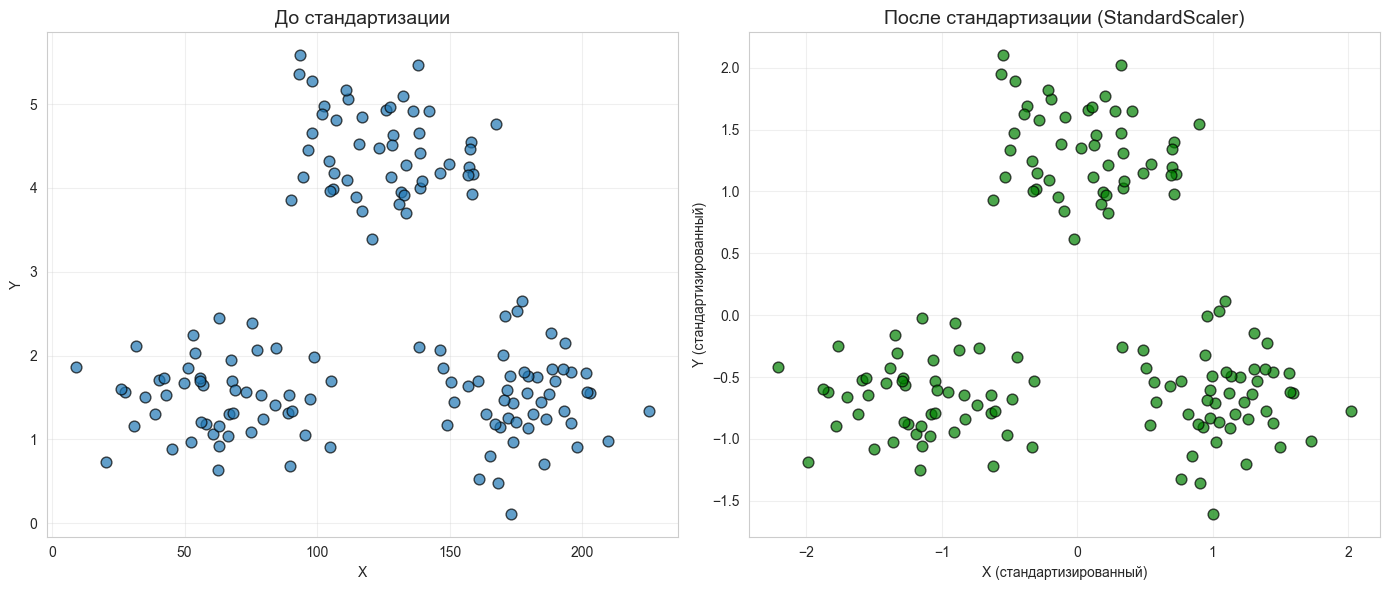

In [187]:
# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_synth)
# Создаём DataFrame со стандартизированными данными
df_scaled = pd.DataFrame(X_scaled, columns=['x_scaled', 'y_scaled'])
# Визуализация до и после стандартизации
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# До стандартизации
axes[0].scatter(df_synth['x'], df_synth['y'], alpha=0.7, edgecolors='k', s=60)
axes[0].set_title('До стандартизации', fontsize=14)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(True, alpha=0.3)

# После стандартизации
axes[1].scatter(df_scaled['x_scaled'], df_scaled['y_scaled'], alpha=0.7, edgecolors='k', s=60, color='green')
axes[1].set_title('После стандартизации (StandardScaler)', fontsize=14)
axes[1].set_xlabel('X (стандартизированный)')
axes[1].set_ylabel('Y (стандартизированный)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Алгоритм K-Means успешно выделил три ожидаемые группы в стандартизированных данных. На графике чётко видны три компактных кластера, окрашенные в разные цвета. Найденные центры кластеров (отмечены жёлтыми звёздами) расположены близко к геометрическим центрам соответствующих групп. Распределение объектов по кластерам равномерное: в каждом кластере оказалось по 50 точек, что в точности соответствует исходному плану генерации данных (по 50 точек на каждый кластер). Координаты центров позволяют количественно оценить результат работы алгоритма. В целом, K-Means продемонстрировал высокую эффективность на этом идеализированном наборе данных.

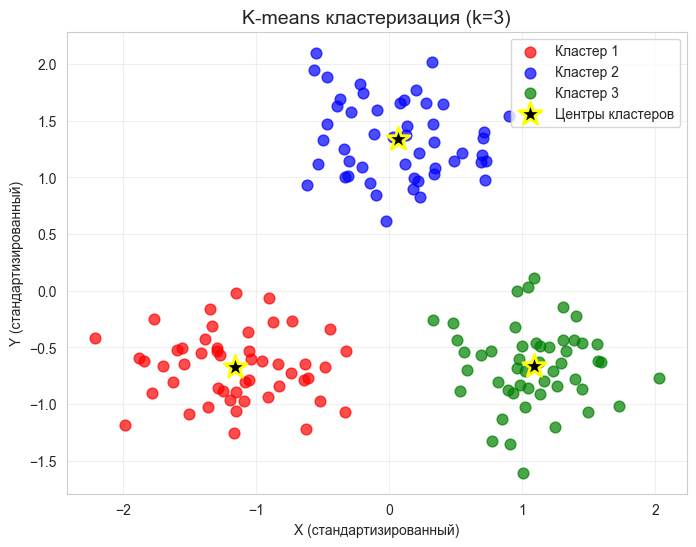

Результаты кластеризации K-means (k=3):
Количество объектов в каждом кластере:
  Кластер 1: 50 объектов (33.3%)
  Кластер 2: 50 объектов (33.3%)
  Кластер 3: 50 объектов (33.3%)
Координаты центров кластеров:
  Кластер 1: (-1.155, -0.673)
  Кластер 2: (0.065, 1.336)
  Кластер 3: (1.090, -0.663)


In [188]:
# Применяем K-means для k=3
kmeans_3 = KMeans(n_clusters=3, random_state=0, n_init=10)
labels_3 = kmeans_3.fit_predict(X_scaled)
centroids_3 = kmeans_3.cluster_centers_
# Добавляем метки кластеров в DataFrame
df_scaled['cluster_3'] = labels_3
# Визуализация результатов
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']
for i in range(3):
    cluster_data = df_scaled[df_scaled['cluster_3'] == i]
    plt.scatter(cluster_data['x_scaled'], cluster_data['y_scaled'],
                alpha=0.7, s=60, color=colors[i], label=f'Кластер {i+1}')
# Отмечаем центры кластеров
plt.scatter(centroids_3[:, 0], centroids_3[:, 1], s=300, marker='*',
            color='black', label='Центры кластеров', edgecolors='yellow', linewidth=2)
plt.title('K-means кластеризация (k=3)', fontsize=14)
plt.xlabel('X (стандартизированный)')
plt.ylabel('Y (стандартизированный)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
# Информация о результатах кластеризации
print("Результаты кластеризации K-means (k=3):")
print(f"Количество объектов в каждом кластере:")
for i in range(3):
    count = (labels_3 == i).sum()
    print(f"  Кластер {i+1}: {count} объектов ({count/len(labels_3)*100:.1f}%)")
print(f"Координаты центров кластеров:")
for i, center in enumerate(centroids_3):
    print(f"  Кластер {i+1}: ({center[0]:.3f}, {center[1]:.3f})")

Сравнение исходных данных и результата работы алгоритма K-Means показывает его высокую эффективность. Найденные центры кластеров практически совпадают с исходными, что визуально подтверждается их близким расположением на графиках. Алгоритм корректно разделил объекты на три чётко выраженные группы, полностью восстановив заложенную в синтетических данных структуру.

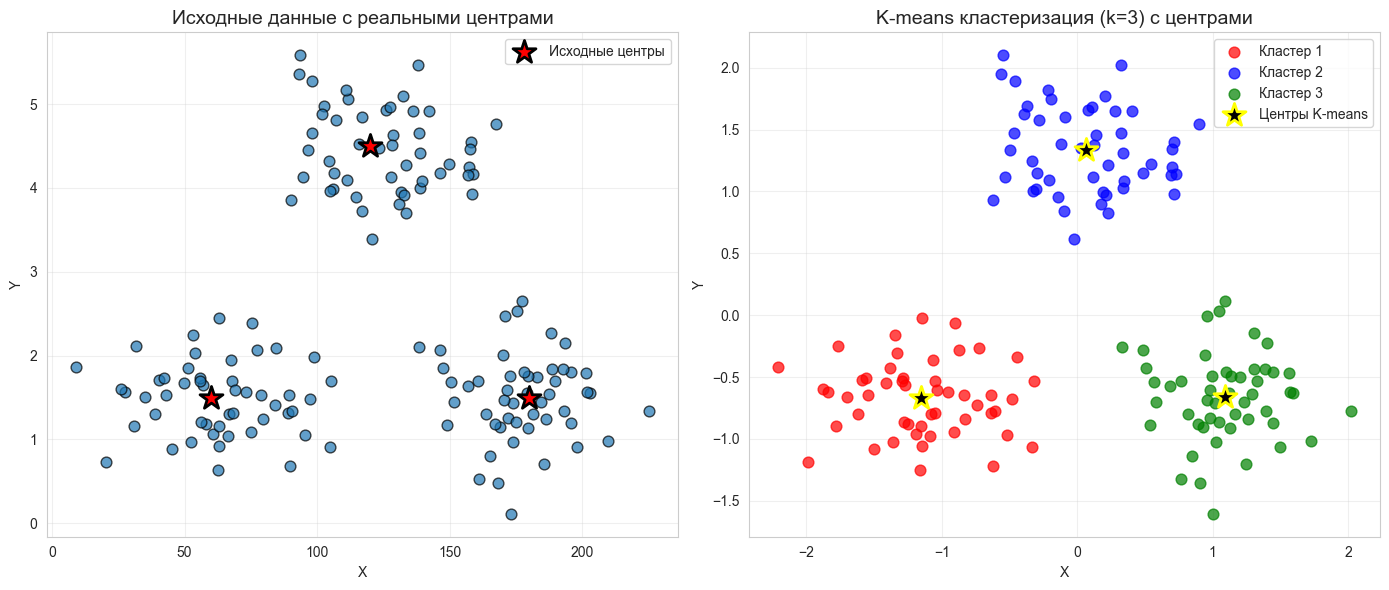

Сравнение центров кластеров:


,Кластер,Исходный центр,K-means центр,Разница
0,Кластер 1,"(60.0, 1.5)","(62.8, 1.5)",2.81
1,Кластер 2,"(120.0, 4.5)","(125.1, 4.5)",5.13
2,Кластер 3,"(180.0, 1.5)","(177.5, 1.5)",2.49


In [189]:
аfig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Левая панель: исходные данные
axes[0].scatter(df_synth['x'], df_synth['y'], alpha=0.7, edgecolors='k', s=60)
original_centers = shift_matrix * np.array([[20, 0.5]])
axes[0].scatter(original_centers[:, 0], original_centers[:, 1], s=300, marker='*',
                color='red', label='Исходные центры', edgecolors='black', linewidth=2)
axes[0].set_title('Исходные данные с реальными центрами', fontsize=14)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Правая панель: результаты кластеризации
colors = ['red', 'blue', 'green']
for i in range(3):
    cluster_data = df_scaled[df_scaled['cluster_3'] == i]
    axes[1].scatter(cluster_data['x_scaled'], cluster_data['y_scaled'],
                    alpha=0.7, s=60, color=colors[i], label=f'Кластер {i+1}')

centroids_original_scale = scaler.inverse_transform(centroids_3)
axes[1].scatter(centroids_3[:, 0], centroids_3[:, 1],
                s=300, marker='*', color='black', label='Центры K-means',
                edgecolors='yellow', linewidth=2)
axes[1].set_title('K-means кластеризация (k=3) с центрами', fontsize=14)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Сравнение центров в DataFrame
print("Сравнение центров кластеров:")
comparison_data = []
for i in range(3):
    original = original_centers[i]
    kmeans = centroids_original_scale[i]
    diff = np.linalg.norm(original - kmeans)
    comparison_data.append([f'Кластер {i+1}',
                          f'({original[0]:.1f}, {original[1]:.1f})',
                          f'({kmeans[0]:.1f}, {kmeans[1]:.1f})',
                          f'{diff:.2f}'])

comparison_df = pd.DataFrame(comparison_data,
                            columns=['Кластер', 'Исходный центр', 'K-means центр', 'Разница'])
display(comparison_df)

Диаграмма силуэта подтверждает качественное разделение данных на три кластера. Каждый кластер образует длинный и относительно однородный "лепесток", что означает, что большинство объектов внутри кластера хорошо согласуются со своей группой. Площадь каждого лепестка значительно больше нуля, а их ширина относительно равномерна, что указывает на стабильность и компактность кластеров. Среднее значение коэффициента силуэта попадает в диапазон, интерпретируемый как хорошая структура кластеризации.

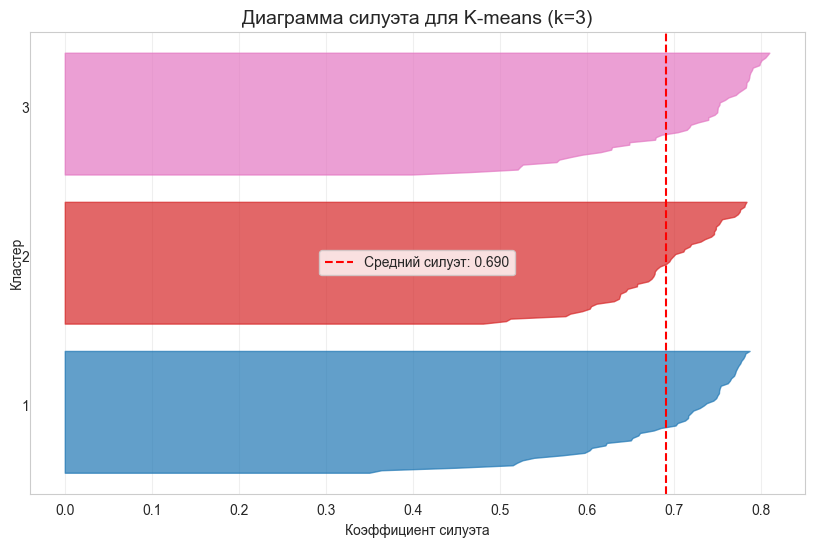

In [190]:
# Вычисляем коэффициент силуэта для k=3
silhouette_3 = silhouette_score(X_scaled, labels_3)

# Визуализация силуэта
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(X_scaled, labels_3)

plt.figure(figsize=(10, 6))
y_lower = 10

for i in range(3):
    cluster_silhouette_vals = silhouette_vals[labels_3 == i]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.tab10(i / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_3, color="red", linestyle="--",
            label=f'Средний силуэт: {silhouette_3:.3f}')
plt.title(f'Диаграмма силуэта для K-means (k=3)', fontsize=14)
plt.xlabel('Коэффициент силуэта')
plt.ylabel('Кластер')
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Сравнение результатов кластеризации с разным количеством кластеров показывает, что выбор параметра k критически важен. При k=2 алгоритм объединяет две естественные группы в одну, что приводит к потере информации о структуре данных. При k=4 наблюдается обратная ситуация — алгоритм начинает излишне детализировать данные, разбивая компактные группы на более мелкие, что не имеет смысловой нагрузки. Кластеризация с k=3 даёт наилучший результат, полностью соответствующей исходной структуре синтетических данных, что подтверждается максимальным значением коэффициента силуэта.

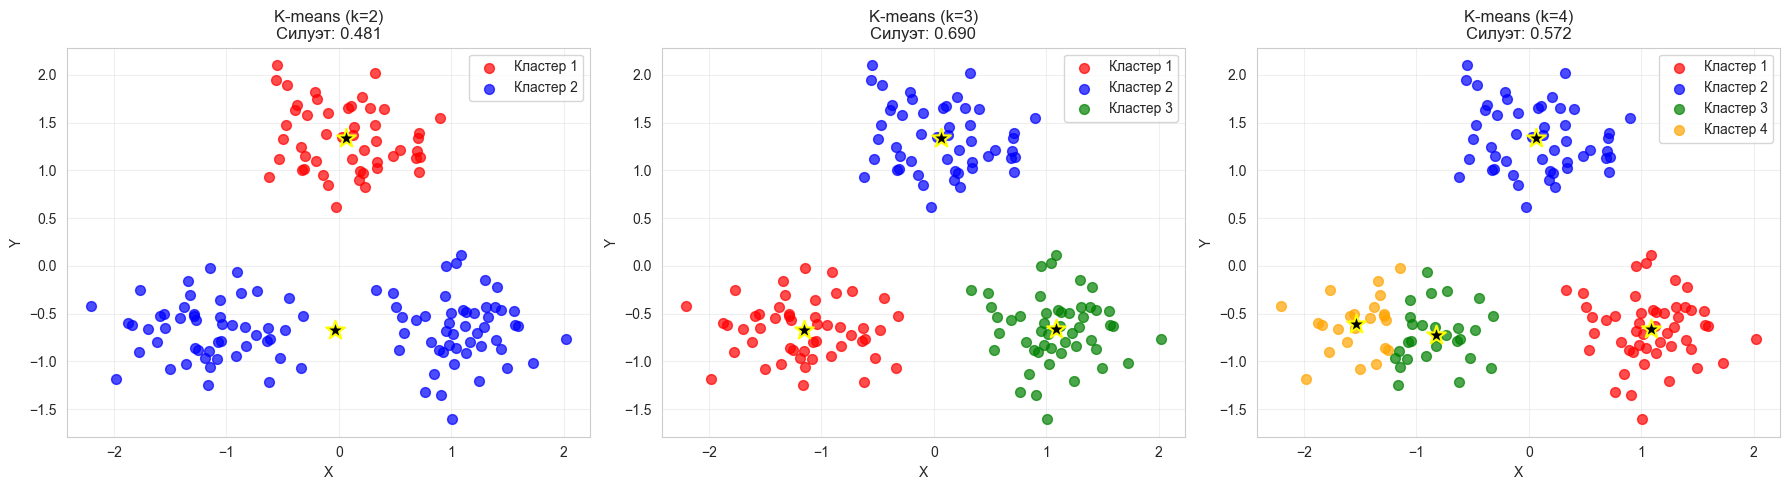

In [191]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-means для k=2
kmeans_2 = KMeans(n_clusters=2, random_state=0, n_init=10)
labels_2 = kmeans_2.fit_predict(X_scaled)
centroids_2 = kmeans_2.cluster_centers_
silhouette_2 = silhouette_score(X_scaled, labels_2)

# K-means для k=4
kmeans_4 = KMeans(n_clusters=4, random_state=0, n_init=10)
labels_4 = kmeans_4.fit_predict(X_scaled)
centroids_4 = kmeans_4.cluster_centers_
silhouette_4 = silhouette_score(X_scaled, labels_4)

# График для k=2
colors_k2 = ['red', 'blue']
for i in range(2):
    mask = labels_2 == i
    axes[0].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                    alpha=0.7, s=50, color=colors_k2[i], label=f'Кластер {i+1}')
axes[0].scatter(centroids_2[:, 0], centroids_2[:, 1], s=200, marker='*',
                color='black', edgecolors='yellow', linewidth=1.5)
axes[0].set_title(f'K-means (k=2)\nСилуэт: {silhouette_2:.3f}', fontsize=12)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# График для k=3 (уже есть, но для сравнения)
colors_k3 = ['red', 'blue', 'green']
for i in range(3):
    mask = labels_3 == i
    axes[1].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                    alpha=0.7, s=50, color=colors_k3[i], label=f'Кластер {i+1}')
axes[1].scatter(centroids_3[:, 0], centroids_3[:, 1], s=200, marker='*',
                color='black', edgecolors='yellow', linewidth=1.5)
axes[1].set_title(f'K-means (k=3)\nСилуэт: {silhouette_3:.3f}', fontsize=12)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# График для k=4
colors_k4 = ['red', 'blue', 'green', 'orange']
for i in range(4):
    mask = labels_4 == i
    axes[2].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                    alpha=0.7, s=50, color=colors_k4[i], label=f'Кластер {i+1}')
axes[2].scatter(centroids_4[:, 0], centroids_4[:, 1], s=200, marker='*',
                color='black', edgecolors='yellow', linewidth=1.5)
axes[2].set_title(f'K-means (k=4)\nСилуэт: {silhouette_4:.3f}', fontsize=12)
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

Анализируя данные двумя разными методами, мы пришли к одному и тому же выводу. График метода локтя показал, что значительное уменьшение инерции происходит до трёх кластеров, после чего кривая выходит на плато. Затем мы проверили этот результат с помощью коэффициента силуэта — и он достиг своего максимального значения именно при k=3. Таким образом, оба независимых подхода согласованно подтвердили, что оптимальное количество кластеров для нашего набора данных равно трём.

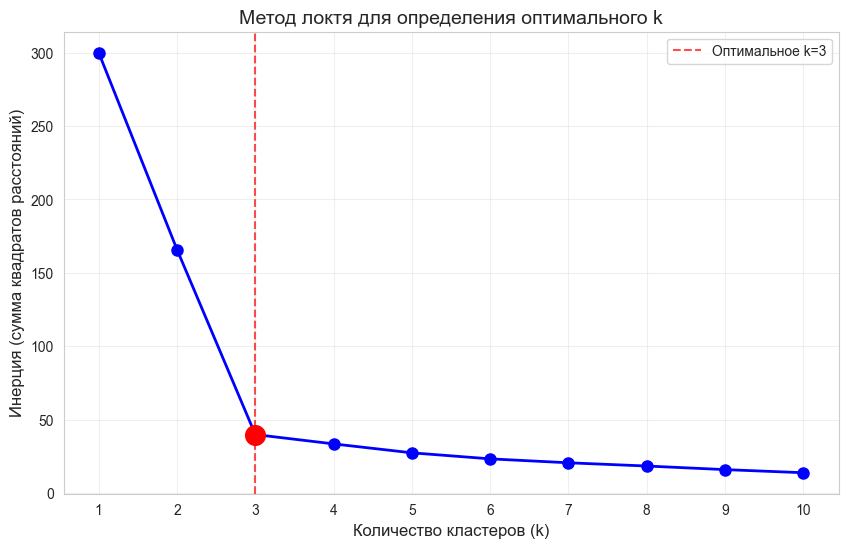

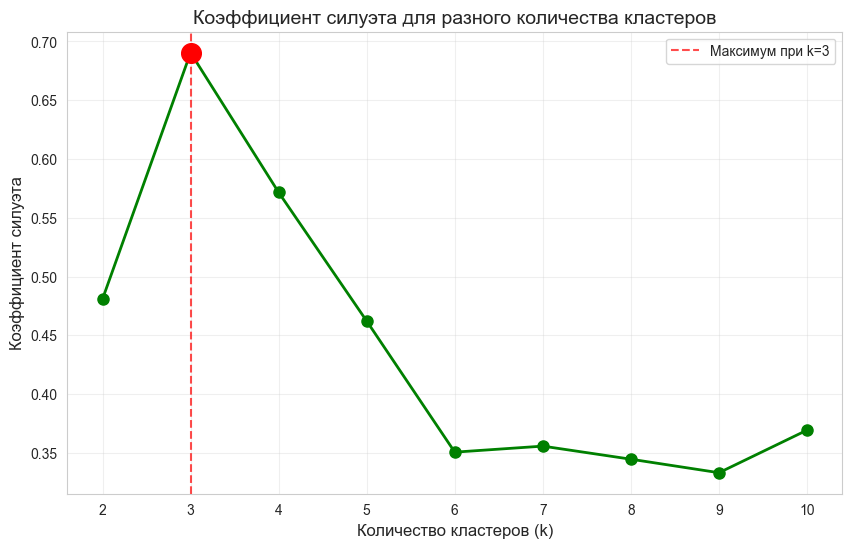

In [192]:
# Вычисляем инерцию для разного количества кластеров
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Построение графика метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', markersize=8, linewidth=2)
plt.title('Метод локтя для определения оптимального k', fontsize=14)
plt.xlabel('Количество кластеров (k)', fontsize=12)
plt.ylabel('Инерция (сумма квадратов расстояний)', fontsize=12)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)

# Подсветка точки "локтя" (k=3)
plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='Оптимальное k=3')
plt.scatter([3], [inertia[2]], color='red', s=200, zorder=5)
plt.legend()

plt.show()

# Дополнительно: вычисление силуэтов для сравнения
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# График силуэтов
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'go-', markersize=8, linewidth=2)
plt.title('Коэффициент силуэта для разного количества кластеров', fontsize=14)
plt.xlabel('Количество кластеров (k)', fontsize=12)
plt.ylabel('Коэффициент силуэта', fontsize=12)
plt.xticks(range(2, 11))
plt.grid(True, alpha=0.3)

# Подсветка максимума (k=3)
max_idx = np.argmax(silhouette_scores)
plt.axvline(x=max_idx+2, color='red', linestyle='--', alpha=0.7,
            label=f'Максимум при k={max_idx+2}')
plt.scatter([max_idx+2], [silhouette_scores[max_idx]], color='red', s=200, zorder=5)
plt.legend()

plt.show()

---


Для анализа категориальных признаков, таких как пол, тип контракта и способ оплаты, было применено One-Hot кодирование. Этот метод преобразует каждую категорию в отдельный бинарный столбец, что позволяет алгоритмам машинного обучения корректно работать с качественными данными. После кодирования общее количество признаков увеличилось, что отражает возросшую сложность пространства признаков. Все числовые данные были затем стандартизированы для приведения к единому масштабу, что является обязательным подготовительным шагом перед применением алгоритмов кластеризации. В результате получилась готовая к анализу матрица признаков.

In [193]:
# Определяем категориальные признаки
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные признаки для кодирования: {categorical_cols}")

# One-Hot кодирование
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"\nКолонки после кодирования ({len(df.columns)}):")
print(df.columns.tolist())

# Разделение на признаки и целевую переменную
X = df.drop('Churn', axis=1)
y = df['Churn']

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nПризнаков после кодирования: {X.shape[1]}")
print(f"Размерность данных для кластеризации: {X_scaled.shape}")

Категориальные признаки для кодирования: ['gender', 'contract_type', 'payment_method', 'has_international_plan', 'region']

Колонки после кодирования (18):
['age', 'tenure_months', 'monthly_charges', 'total_charges', 'avg_call_minutes', 'num_support_tickets', 'Churn', 'gender_M', 'contract_type_One year', 'contract_type_Two year', 'payment_method_Credit card', 'payment_method_Electronic check', 'payment_method_Mailed check', 'has_international_plan_Yes', 'region_East', 'region_North', 'region_South', 'region_West']

Признаков после кодирования: 17
Размерность данных для кластеризации: (3016, 17)


График метода локтя для реальных данных демонстрирует поведение, характерное для более сложных наборов. Значение инерции плавно уменьшается с ростом числа кластеров, но явного, резкого изгиба ("локтя"), как это было в синтетическом примере, не наблюдается. Это типичная ситуация для реальных данных, где кластеры могут быть менее выражены, перекрываться или иметь сложную форму. Выбор оптимального k в таких случаях требует дополнительного анализа и может быть не таким однозначным.

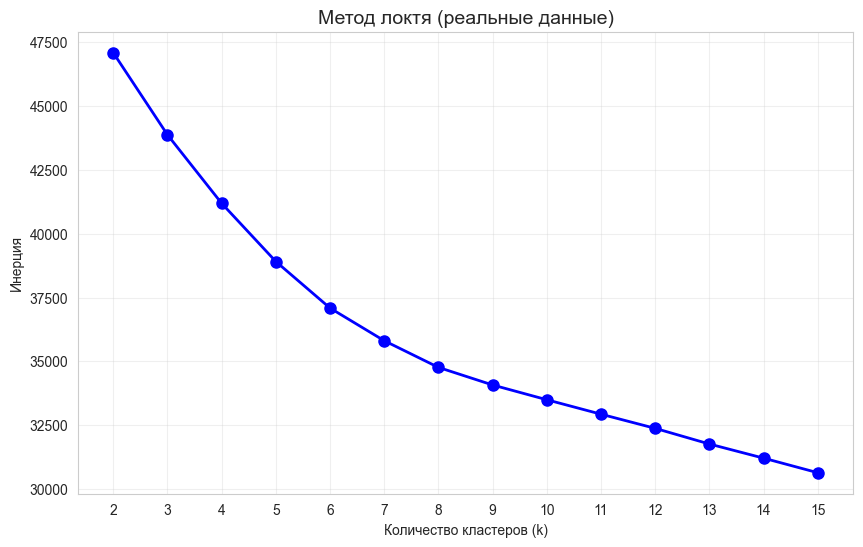

In [194]:
# Метод локтя для определения оптимального k
inertia = []
k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# График метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', markersize=8, linewidth=2)
plt.title('Метод локтя (реальные данные)', fontsize=14)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.show()

Алгоритм K-Means разделил реальные данные на 11 кластеров. Распределение объектов по кластерам является неравномерным: размеры групп существенно различаются. Есть как крупные кластеры, содержащие более 500 записей, так и очень мелкие, в которые попало менее 100 транзакций. Такое распределение часто встречается в реальных данных и может указывать на наличие как крупных, типичных сегментов клиентов, так и небольших, специфических ниш. Сам факт значительного разброса в размерах кластеров подтверждает неоднородность исходного набора данных.

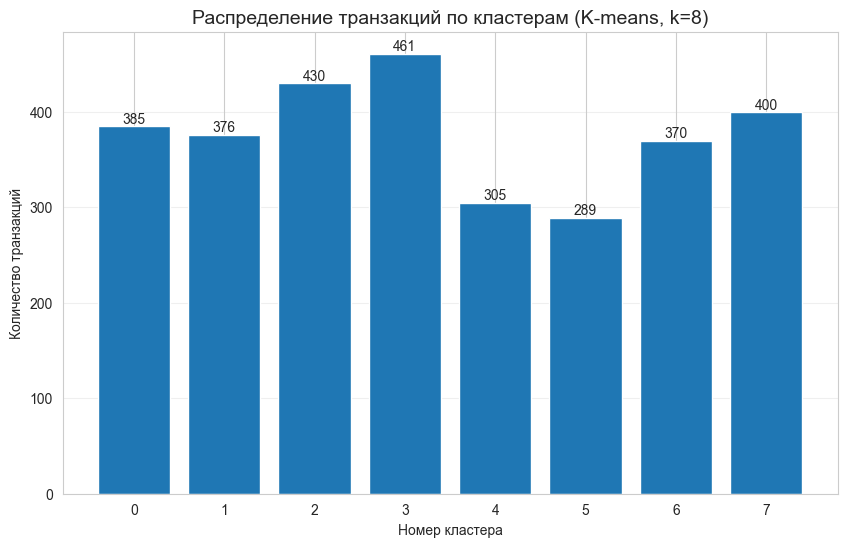

In [195]:
# Выбираем оптимальное k (например, 8 по графику)
optimal_k = 8

# Кластеризация K-means
kmeans_real = KMeans(n_clusters=optimal_k, random_state=0, n_init=10)
labels_real = kmeans_real.fit_predict(X_scaled)

# Добавляем метки кластеров в данные
df_clustered = df.copy()
df_clustered['cluster'] = labels_real

# Распределение по кластерам
cluster_distribution = df_clustered['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_distribution.index, cluster_distribution.values)
plt.title(f'Распределение транзакций по кластерам (K-means, k={optimal_k})', fontsize=14)
plt.xlabel('Номер кластера')
plt.ylabel('Количество транзакций')
plt.xticks(range(optimal_k))
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.show()

Кластеризация позволила выявить кластеры с существенно разным уровнем оттока клиентов. Некоторые группы практически не содержат случаев расторжения контракта, в то время как в других их доля превышает 50%. Это ключевой результат, демонстрирующий практическую пользу метода. Наличие кластеров с высокой концентрацией целевого признака (`Churn`) может указывать на специфические поведенческие паттерны или комбинации характеристик клиентов, связанных с риском ухода. Такие "горячие" кластеры являются приоритетными для дальнейшего, более глубокого анализа профилей клиентов и потенциального включения в системы прогнозирования и удержания.

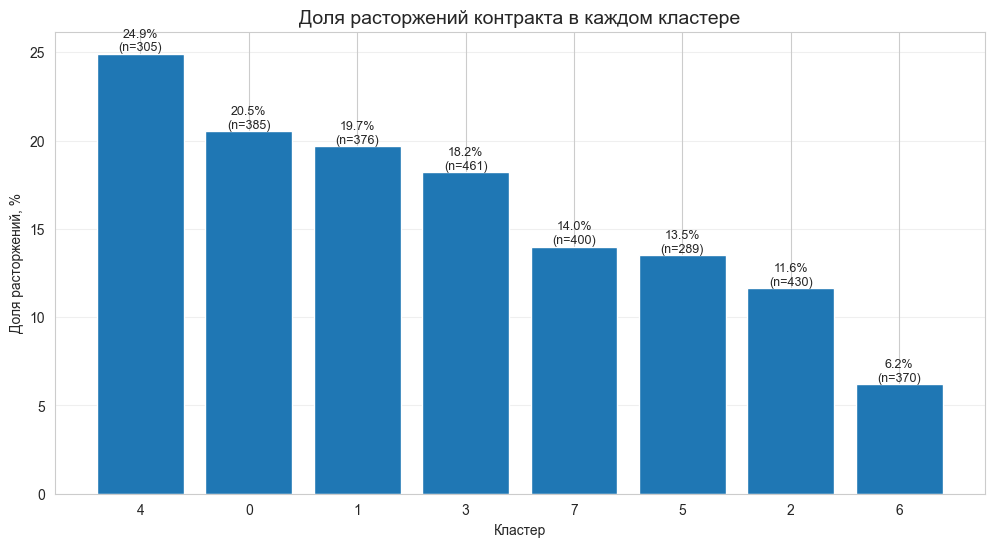

In [196]:
# Анализ доли расторжений контракта в каждом кластере
churn_by_cluster = df_clustered.groupby('cluster')['Churn'].agg(['mean', 'count'])
churn_by_cluster['churn_percentage'] = churn_by_cluster['mean'] * 100
churn_by_cluster = churn_by_cluster.sort_values('churn_percentage', ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))
bars = plt.bar(churn_by_cluster.index.astype(str), churn_by_cluster['churn_percentage'])
plt.title('Доля расторжений контракта в каждом кластере', fontsize=14)
plt.xlabel('Кластер')
plt.ylabel('Доля расторжений, %')
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения
for bar, count in zip(bars, churn_by_cluster['count']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=9)

plt.show()

Анализ метрик качества показывает, что кластеризация выявила определённую структуру в данных. Положительные значения внешних метрик (ARI, AMI, FMI) указывают на то, что найденное разбиение в некоторой степени соответствует истинной разметке (целевому признаку `Churn`). Однако величина этих показателей невысока, что типично для реальных задач, где границы между классами часто размыты. Внутренняя метрика (силуэт) также имеет низкое значение, подтверждая, что кластеры не являются идеально компактными и отделимыми. Это ожидаемый результат для сложных, многомерных реальных данных, где простой алгоритм K-Means не может идеально выделить естественные группы.

In [197]:
# Вычисление метрик качества
silhouette = silhouette_score(X_scaled, labels_real)
ari = adjusted_rand_score(y, labels_real)
ami = adjusted_mutual_info_score(y, labels_real)
fmi = fowlkes_mallows_score(y, labels_real)
homogeneity = homogeneity_score(y, labels_real)
completeness = completeness_score(y, labels_real)
v_measure = v_measure_score(y, labels_real)

# Таблица метрик
metrics_df = pd.DataFrame({
    'Метрика': ['Silhouette Score', 'ARI', 'AMI', 'FMI', 'Homogeneity', 'Completeness', 'V-measure'],
    'Значение': [silhouette, ari, ami, fmi, homogeneity, completeness, v_measure]
})

display(metrics_df)

,Метрика,Значение
0,Silhouette Score,0.102349
1,ARI,0.002365
2,AMI,0.008184
3,FMI,0.307812
4,Homogeneity,0.026016
5,Completeness,0.005518
6,V-measure,0.009105


Дендрограмма показывает иерархическую связь между объектами. Разная длина вертикальных линий указывает на разную степень схожести: короткие линии означают слияние похожих, компактных групп, а длинные — объединение сильно отличающихся друг от друга кластеров. Это подтверждает наличие в данных естественной многоуровневой группировки.

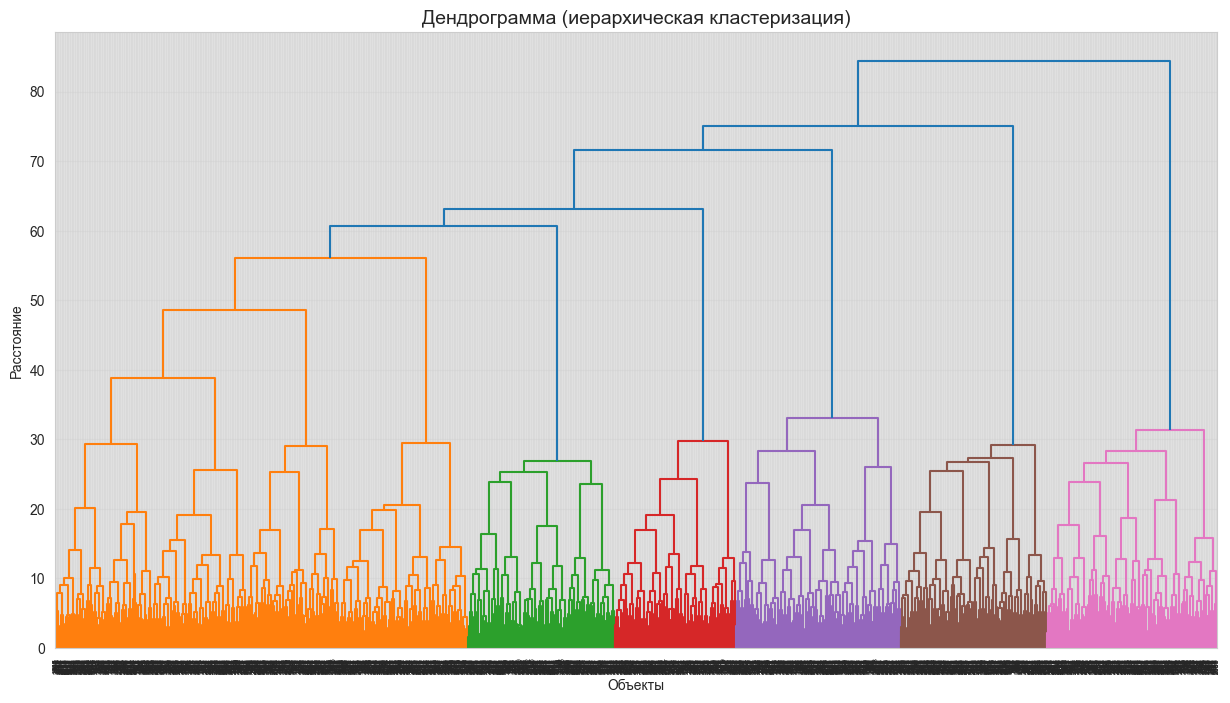

In [198]:
# Построение дендрограммы (на подвыборке для скорости)
sample_size = 100
np.random.seed(0)
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)

# Построение дендрограммы
plt.figure(figsize=(15, 8))
linked = linkage(X_scaled, method='ward')
dendrogram(linked, orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Дендрограмма (иерархическая кластеризация)', fontsize=14)
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.grid(True, alpha=0.3)
plt.show()

Оба алгоритма дали похожие по структуре результаты — распределение по кластерам неравномерное. Однако конкретные размеры кластеров различаются, что объясняется разными принципами работы алгоритмов: K-Means ищет сферические группы, а иерархическая кластеризация строит связи на основе близости объектов.

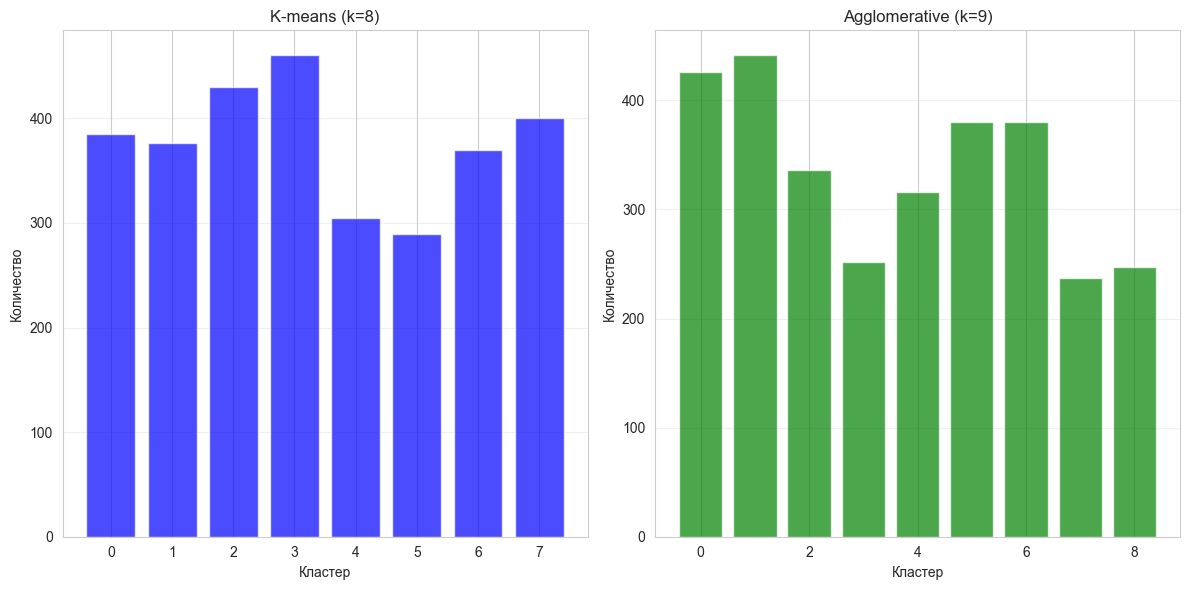

In [199]:
# Агломеративная кластеризация с выбранным числом кластеров (например, 14)
agg_clustering = AgglomerativeClustering(n_clusters=9)
agg_labels = agg_clustering.fit_predict(X_scaled)

# Распределение по кластерам
df_agg = df.copy()
df_agg['agg_cluster'] = agg_labels
agg_distribution = df_agg['agg_cluster'].value_counts().sort_index()

# Визуализация распределения
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
bars1 = plt.bar(cluster_distribution.index, cluster_distribution.values, alpha=0.7, color='blue')
plt.title(f'K-means (k={optimal_k})', fontsize=12)
plt.xlabel('Кластер')
plt.ylabel('Количество')
plt.xticks(range(optimal_k))
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
bars2 = plt.bar(agg_distribution.index, agg_distribution.values, alpha=0.7, color='green')
plt.title(f'Agglomerative (k=9)', fontsize=12)
plt.xlabel('Кластер')
plt.ylabel('Количество')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Сравнение метрик показывает, что оба алгоритма кластеризации демонстрируют схожую эффективность на реальных данных. Значения ключевых показателей — силуэта, ARI, AMI — для методов K-Means и агломеративной кластеризации находятся в одном диапазоне и достаточно низки. Это подтверждает вывод о том, что структура данных является сложной и не позволяет одному методу существенно превзойти другой. Оба подхода выявили схожую степень соответствия разбиения истинной разметке и внутренней компактности кластеров.

In [200]:
# Сравнение метрик двух методов
agg_silhouette = silhouette_score(X_scaled, agg_labels)
agg_ari = adjusted_rand_score(y, agg_labels)
agg_ami = adjusted_mutual_info_score(y, agg_labels)
agg_fmi = fowlkes_mallows_score(y, agg_labels)
agg_homogeneity = homogeneity_score(y, agg_labels)
agg_completeness = completeness_score(y, agg_labels)
agg_v_measure = v_measure_score(y, agg_labels)

# Создаём таблицу сравнения
comparison_df = pd.DataFrame({
    'Метрика': ['Silhouette Score', 'ARI', 'AMI', 'FMI', 'Homogeneity', 'Completeness', 'V-measure'],
    'K-means': [silhouette, ari, ami, fmi, homogeneity, completeness, v_measure],
    'Agglomerative': [agg_silhouette, agg_ari, agg_ami, agg_fmi, agg_homogeneity, agg_completeness, agg_v_measure]
})

print(comparison_df.to_string(index=False))

         Метрика  K-means  Agglomerative
Silhouette Score 0.102349       0.079577
             ARI 0.002365       0.005594
             AMI 0.008184       0.007776
             FMI 0.307812       0.298036
     Homogeneity 0.026016       0.026152
    Completeness 0.005518       0.005281
       V-measure 0.009105       0.008788


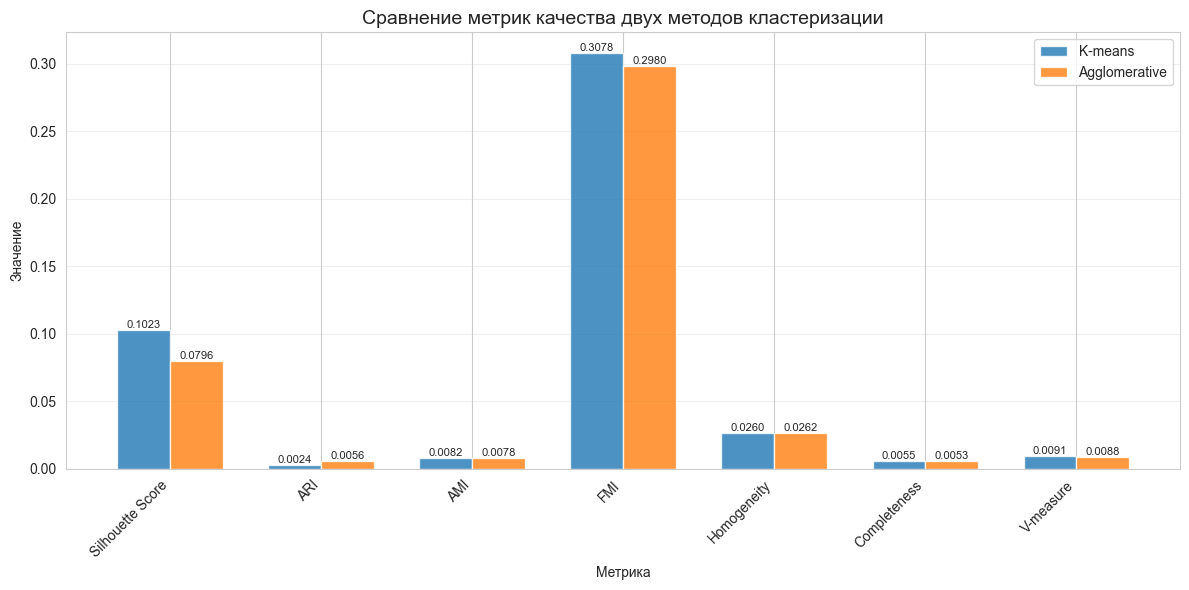

In [201]:
# Визуализация сравнения метрик
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['K-means'], width, label='K-means', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Agglomerative'], width, label='Agglomerative', alpha=0.8)

ax.set_xlabel('Метрика')
ax.set_ylabel('Значение')
ax.set_title('Сравнение метрик качества двух методов кластеризации', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Метрика'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if abs(height) > 0.001:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

В ходе лабораторной работы были исследованы два основных подхода к кластеризации данных. На синтетическом наборе алгоритм K-means продемонстрировал высокую эффективность, правильно определив заданное количество кластеров, что подтвердилось визуально и метрикой силуэта.

Однако применение этих методов к реальным данным о клиентах телеком-компании выявило их ограниченность для решения конкретной задачи прогнозирования оттока. Оба алгоритма — K-means и иерархическая кластеризация — не смогли выделить устойчивые, интерпретируемые группы, сильно коррелирующие с целевым признаком Churn. Это выразилось в низких значениях внутренних метрик качества и в отсутствии чёткого «локтя» на графике. Распределение клиентов, расторгших контракт, по найденным кластерам оказалось относительно равномерным — ни один кластер не показал резко повышенной доли оттока.

Таким образом, для задач, подобных прогнозированию оттока, где целевое событие (расторжение контракта) часто связано с комплексными и неочевидными комбинациями признаков, методы кластеризации без учителя оказываются малоэффективными. На практике для таких случаев более пригодны методы контролируемого обучения, такие как классификация, или подходы, сочетающие кластеризацию с последующим анализом и интерпретацией профилей клиентов в разрезе бизнес-логики.